In [ ]:
#This notebook is used to reproduce the findings in this paper: https://www.sciencedirect.com/science/article/pii/S2352914821000356
#Elujide, Israel, et al. "Application of deep and machine learning techniques for multi-label classification performance on psychotic disorder diseases." Informatics in Medicine Unlocked 23 (2021): 100545.

#This paper doesn't provide any code repo

#The libraries include torch, pandas, numpy, matplotlib, imbalanced-learn and sklearn.

#Data can be downloaded from this paper's supplementary material:
#https://www.sciencedirect.com/science/article/pii/S2352340917303487

#Preprocessing code: 0. SMOTE.ipynb

#Imbalanced dataset training and validation: 1_imbalanced data_train+eval.ipynb

#Balanced dataset training and validation: 2_balanced data_train+eval.ipynb

#Pretrained model: see .pt files

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os
from tqdm import tqdm

In [3]:
# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
batch_size = 50
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Get the row at the specified index
        row = self.data.iloc[index]
        
        # Extract the features and label
        features = row[1:-5].values.astype(float)
        label = row[-5:]
        
        # Convert the label to a tensor
        label_tensor = torch.tensor(label)
        
        # Convert the features to a tensor
        features_tensor = torch.tensor(features)
        
        # Return the features and label as a tuple
        return features_tensor, label_tensor


b_data = MyDataset('./data_balanced.csv')

b_train_size = int(0.7 * len(b_data))
b_val_size = len(b_data) - b_train_size
b_train_data, b_val_data = torch.utils.data.random_split(dataset = b_data, lengths = [0.7, 0.3 ])
b_train_loader = DataLoader(b_train_data, batch_size=batch_size, shuffle=True)
b_val_loader = DataLoader(b_val_data, batch_size=batch_size, shuffle=False)

print(len(b_train_data), len(b_val_data))

for batch in b_val_loader:
  print((batch[0][0].dtype))


849 363
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64


In [5]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.fc1 = nn.Linear(26, 15)
        self.fc2 = nn.Linear(15, 20)
        #self.dropout = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 40)
        self.fc5 = nn.Linear(40, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return nn.functional.sigmoid(x)

model = DNN()
print(model)

DNN(
  (fc1): Linear(in_features=26, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=5, bias=True)
)


In [6]:
def evaluate(model, loader):
    val_loss_arr = []
    val_accu_arr = []
    model.eval()
    val_loss = 0
    total_correct = 0
    total_samples = 0
    for x, y in loader:
        y_hat = model(x.to(torch.float32))
        #y_hat = y_hat.view(y_hat.shape[0])
        loss = criterion(y_hat, y.to(torch.float32))
        val_loss += loss.item()
        

        y_hat[y_hat>0.5] = 1
        y_hat[y_hat<=0.5] = 0
        y_pred = y_hat
        
        total_samples += y.size(0)
        total_match =  (y_pred == y.to(torch.float32))
        
        #print(total_match)
        for i in total_match:
          if i.numpy().sum() == 5:
            total_correct += 1
        
    val_loss = val_loss / len(b_val_loader) 
    #print(total_correct, val_loss)   
    val_accuracy = total_correct / total_samples

    print('\tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}'.format(val_loss, val_accuracy))
    return val_loss, val_accuracy

In [20]:
lr = 0.01
n_epochs = 40
delta_val_loss = 1
model = DNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_arr = []
train_accu_arr = []
val_loss_arr = []
val_accu_arr = []
epoch_runtimes = []
import time 
for epoch in range(n_epochs):
    model.train()
    start_time = time.time()
    train_loss = 0
    total_correct = 0
    total_samples = 0
    for x, y in b_train_loader:

        optimizer.zero_grad()

        y_hat = model.forward(x.to(torch.float32))
        #print(y_hat.shape, x.shape, y.shape)
        #y_hat = y_hat.view(y_hat.shape[0])
        loss = criterion(y_hat, y.to(torch.float32))
        #print(loss)
        predicted = torch.Tensor(np.round(y_hat.detach().numpy()))
        total_samples += y.size(0)
        #print(predicted.dtype, y.dtype, y.to(torch.float32).dtype)
        #print((predicted == y.to(torch.float32)))
        total_match =  (predicted == y.to(torch.float32))
        for i in total_match:
          if i.numpy().sum() == 5:
            total_correct += 1

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss / len(b_train_loader)
    train_loss_arr.append(train_loss)
    train_accuracy = total_correct / total_samples
    train_accu_arr.append(train_accuracy)
    print('Epoch: {} \tTraining Loss: {:.6f}\tTraining Accuracy: {:.6f}'.format(epoch, train_loss, train_accuracy))
    temp1, temp2 = evaluate(model, b_val_loader)
    val_loss_arr.append(temp1)
    val_accu_arr.append(temp2)
    if len(val_loss_arr)>1 and val_loss_arr[-1] - val_loss_arr[-2] > delta_val_loss:
      break
    else:
      torch.save(model.state_dict(), './model.pt')

end_time = time.time()
epoch_runtime = end_time - start_time
epoch_runtimes.append(epoch_runtime)
avg_epoch_runtime = sum(epoch_runtimes) / len(epoch_runtimes)
print(f"Total epoch number = {epoch+1}: average runtime = {avg_epoch_runtime:.2f} seconds")

Epoch: 0 	Training Loss: 0.625620	Training Accuracy: 0.117786
	Validation Loss: 0.573674	Validation Accuracy: 0.225895
Epoch: 1 	Training Loss: 0.529311	Training Accuracy: 0.296820
	Validation Loss: 0.518455	Validation Accuracy: 0.322314
Epoch: 2 	Training Loss: 0.492813	Training Accuracy: 0.341578
	Validation Loss: 0.521065	Validation Accuracy: 0.352617
Epoch: 3 	Training Loss: 0.490568	Training Accuracy: 0.367491
	Validation Loss: 0.484718	Validation Accuracy: 0.385675
Epoch: 4 	Training Loss: 0.465100	Training Accuracy: 0.375736
	Validation Loss: 0.485409	Validation Accuracy: 0.380165
Epoch: 5 	Training Loss: 0.450139	Training Accuracy: 0.409894
	Validation Loss: 0.466120	Validation Accuracy: 0.429752
Epoch: 6 	Training Loss: 0.428692	Training Accuracy: 0.435807
	Validation Loss: 0.490659	Validation Accuracy: 0.294766
Epoch: 7 	Training Loss: 0.411271	Training Accuracy: 0.473498
	Validation Loss: 0.458086	Validation Accuracy: 0.435262
Epoch: 8 	Training Loss: 0.383834	Training Accur

In [23]:
print(np.argmin(val_loss_arr), np.argmax(val_accu_arr))

print(f"max validation accuracy = {max(val_accu_arr):.4f}")

11 32
max validation accuracy = 0.5620


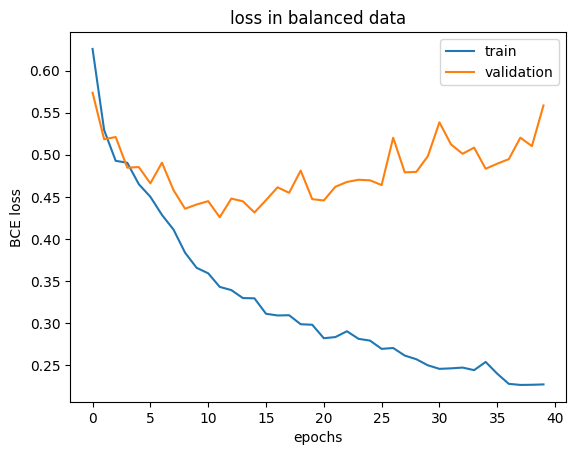

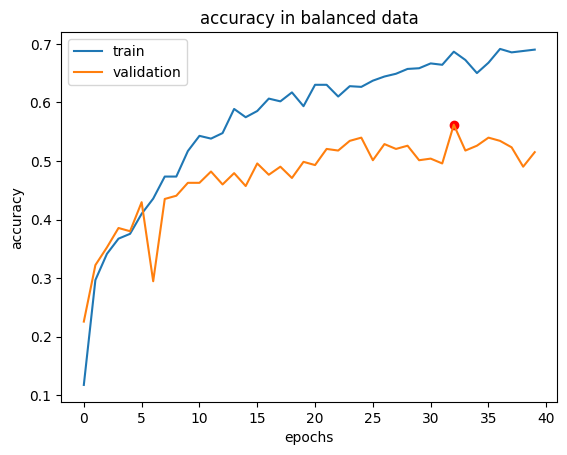

In [29]:
import matplotlib.pyplot as plt
 
plt.plot(train_loss_arr, label="train")
plt.plot(val_loss_arr, label="validation")
plt.xlabel("epochs")
plt.ylabel("BCE loss")
plt.title('loss in balanced data')
plt.legend()
plt.show()
 
plt.plot(train_accu_arr, label="train")
plt.plot(val_accu_arr, label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('accuracy in balanced data')
plt.scatter(np.argmax(val_accu_arr), np.max(val_accu_arr), c='red')
#plt.annotate('Max val accuracy', xy=(np.argmax(val_accu_arr), np.max(val_accu_arr)),
   #          xytext=(np.argmax(val_accu_arr)+1, np.max(val_accu_arr)+0.5))
plt.legend()
plt.show()

In [10]:
import platform
import psutil

# get the system hardware information
system = platform.uname()
cpu = platform.processor()
memory = psutil.virtual_memory()
disk = psutil.disk_usage('/')

# print the system hardware information
print(f"System: {system.system} {system.release} {system.version}")
print(f"CPU: {cpu}")
print(f"Memory: Total={memory.total / 1e9:.2f} GB, Available={memory.available / 1e9:.2f} GB")
print(f"Disk: Total={disk.total / 1e12:.2f} TB, Used={disk.used / 1e12:.2f} TB, Free={disk.free / 1e12:.2f} TB")

System: Linux 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022
CPU: x86_64
Memory: Total=13.62 GB, Available=12.09 GB
Disk: Total=0.24 TB, Used=0.03 TB, Free=0.22 TB


In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
balanced_data = pd.read_csv('./data_balanced.csv')
X = balanced_data.drop(columns=['Unnamed: 0','Insominia', 'shizopherania',
       'vascula_demetia', 'ADHD', 'Bipolar'])
y = balanced_data[['Insominia', 'shizopherania',
       'vascula_demetia', 'ADHD', 'Bipolar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed)
#Multilayer perceptron
MLP = MLPClassifier(random_state=seed).fit(X_train,y_train)
print("MLP accuracy :",MLP.score(X_test,y_test))

#Randowm Forest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=seed).fit(X_train,y_train)
print("RF accuracy :",RF.score(X_test,y_test))

#Decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("DT accuracy :", clf.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP accuracy : 0.6008230452674898
RF accuracy : 0.7325102880658436
DT accuracy : 0.6790123456790124
